In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#FAKE NEWS DATASET

In [26]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/Fake_news_rid.csv


--2022-04-26 07:58:10--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/Fake_news_rid.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.148.74
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.148.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23875091 (23M) [text/csv]
Saving to: ‘Fake_news_rid.csv.1’

Fake_news_rid.csv.1 100%[===================>]  22.77M  11.2MB/s    in 2.0s    

2022-04-26 07:58:12 (11.2 MB/s) - ‘Fake_news_rid.csv.1’ saved [23875091/23875091]



In [27]:
dff = pd.read_csv('Fake_news_rid.csv') 
dff.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [28]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8750 entries, 0 to 8749
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    8750 non-null   object
 1   text     8750 non-null   object
 2   subject  8750 non-null   object
 3   date     8750 non-null   object
dtypes: object(4)
memory usage: 273.6+ KB


In [29]:
dff["subject"].value_counts()

News    8750
Name: subject, dtype: int64

In [30]:
dff["date"].value_counts()

February 16, 2016    32
February 10, 2016    28
April 1, 2016        27
February 7, 2016     26
January 26, 2016     26
                     ..
November 10, 2017     1
November 12, 2017     1
November 19, 2017     1
November 20, 2017     1
October 22, 2017      1
Name: date, Length: 709, dtype: int64

##DATA CLEANING

In [31]:
dff = dff.drop("title",axis=1)

In [32]:
dff = dff.drop("date",axis=1)

In [33]:
dff.rename(columns={"subject":"TypeNews"}, inplace=True)

In [34]:
#  Fakenews = TypeNews : 0
dff.replace({'TypeNews':{'News':0}}, inplace=True)

In [35]:
dff.head()

,text,TypeNews
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [36]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8750 entries, 0 to 8749
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      8750 non-null   object
 1   TypeNews  8750 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 136.8+ KB


In [37]:
import re

def clean_special_patterns(text):
    """Remove special patterns - email, url, date etc."""
    html_regex = re.compile(r"<.*?>")
    email_regex = re.compile(r"[\w.-]+@[\w.-]+")
    url_regex = re.compile(r"(http|www)[^\s]+")
    date_regex = re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?") # a way to match date
    new_line = re.compile(r"/(\r\n)+|\r+|\n+|\t+/")
    number = re.compile(r"[\d+]")
    under = re.compile(r"[^a-zA-Z0-9:$-,%.?!]+")
    simbols = re.compile(r"[^\w\s/'/`]")
    spaces = re.compile(r"\s{2,}")
    remove_singlelett= re.compile(r"(^| ).( |$)")

    ## remove
    text = text.lower()
    text = number.sub(" ", text)
    text = html_regex.sub(" ", text)
    text = url_regex.sub(" ", text)
    text = email_regex.sub(" ", text)
    text = date_regex.sub(" ", text)
    text = new_line.sub(" ", text)
    text = under.sub(" ", text)
    text = simbols.sub(" ", text)
    text = spaces.sub(" ", text)
    text = text.replace("`", "'")
    text = remove_singlelett.sub("",text)
    return text

In [39]:
#Applichiamo la funzione di cleaning all in once
dff["text"] = dff["text"].apply(clean_special_patterns)
dff

,text,TypeNews
0,donald trump just couldnwish all americanshapp...,0
1,house intelligence committee chairman devin nu...,0
2,on friday it was revealed that former milwauke...,0
3,on christmas day donald trump announced that h...,0
4,pope francis used his annual christmas day mes...,0
...,...,...
8745,if thereone thing you never do in life itpiss ...,0
8746,footage has been released ofleader of the repu...,0
8747,put this one under shit you just canmake upuai...,0
8748,ifdebate is won according to who generates the...,0


## STOPWORDS + LEMMATIZATION

In [40]:
## Spacy Custom Pipeline
import numpy as np
import multiprocessing as mp

import string
import spacy 
from sklearn.base import TransformerMixin, BaseEstimator


nlp = spacy.load("en_core_web_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

In [62]:
#takes 2 min of processing
text_preprocess = TextPreprocessor(n_jobs=-1)._preprocess_text
#dff["text"][0:10].apply(text_preprocess)
dff["text"] = dff["text"].apply(text_preprocess)
dff

,text,TypeNews
0,donald trump couldnwish americanshappy new yea...,0
1,house intelligence committee chairman devin nu...,0
2,friday reveal milwaukee sheriff david clarke c...,0
3,christmas day donald trump announce work follo...,0
4,pope francis annual christmas day message rebu...,0
...,...,...
8745,thereone thing life itpiss offnew yorker there...,0
8746,footage release ofleader republican national c...,0
8747,shit canmake upuair force base georgia force p...,0
8748,ifdebate win accord generate buzz bernie sande...,0


##EDA

In [22]:
cleaned = ' '.join(dff['text'].to_list())

(-0.5, 799.5, 399.5, -0.5)

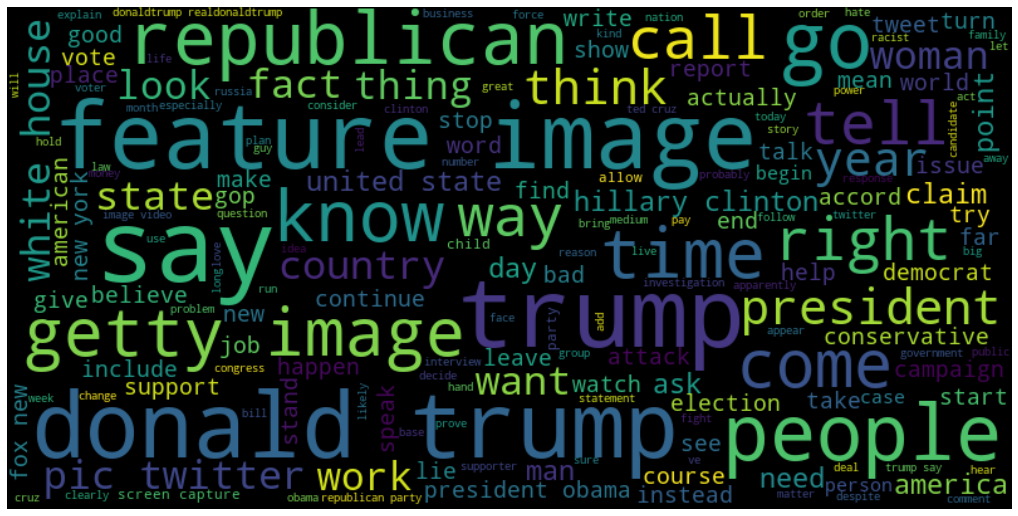

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 667)

wordcloud.generate(cleaned)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

#TRUE NEWS DATASET

In [47]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/True_news_rid.csv

--2022-04-26 08:02:48--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/True_news_rid.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.149.78
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.149.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23478117 (22M) [text/csv]
Saving to: ‘True_news_rid.csv.1’

True_news_rid.csv.1 100%[===================>]  22.39M  11.9MB/s    in 1.9s    

2022-04-26 08:02:50 (11.9 MB/s) - ‘True_news_rid.csv.1’ saved [23478117/23478117]



In [48]:
dft = pd.read_csv('True_news_rid.csv') 
dft.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [49]:
dft["subject"].value_counts()

politicsNews    8750
Name: subject, dtype: int64

##DATA CLEANING

In [50]:
dft = dft.drop("title",axis=1)

In [51]:
dft = dft.drop("date",axis=1)

In [52]:
dft.rename(columns={"subject":"TypeNews"}, inplace=True)

In [53]:
#  Truenews = TypeNews : 1
dft.replace({'TypeNews':{'politicsNews':1}}, inplace=True)

In [54]:
dft

,text,TypeNews
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...
8745,WASHINGTON (Reuters) - Republican Donald Trump...,1
8746,NEW YORK (Reuters) - Many Americans view Islam...,1
8747,WASHINGTON (Reuters) - U.S. House of Represent...,1
8748,WASHINGTON/NEW YORK (Reuters) - Republican Don...,1


In [55]:
import re

def clean_special_patterns(text):
    """Remove special patterns - email, url, date etc."""
    html_regex = re.compile(r"<.*?>")
    email_regex = re.compile(r"[\w.-]+@[\w.-]+")
    url_regex = re.compile(r"(http|www)[^\s]+")
    date_regex = re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?") # a way to match date
    new_line = re.compile(r"/(\r\n)+|\r+|\n+|\t+/")
    number = re.compile(r"[\d+]")
    under = re.compile(r"[^a-zA-Z0-9:$-,%.?!]+")
    simbols = re.compile(r"[^\w\s/'/`]")
    spaces = re.compile(r"\s{2,}")
    remove_singlelett= re.compile(r"(^| ).( |$)")

    ## remove
    text = text.lower()
    text = number.sub(" ", text)
    text = html_regex.sub(" ", text)
    text = url_regex.sub(" ", text)
    text = email_regex.sub(" ", text)
    text = date_regex.sub(" ", text)
    text = new_line.sub(" ", text)
    text = under.sub(" ", text)
    text = simbols.sub(" ", text)
    text = spaces.sub(" ", text)
    text = text.replace("`", "'")
    text = remove_singlelett.sub("",text)
    return text

In [56]:
#Applichiamo la funzione di cleaning all in once
dft["text"] = dft["text"].apply(clean_special_patterns)
dft

,text,TypeNews
0,washington reuters the head ofconservative rep...,1
1,washington reuters transgender people will be ...,1
2,washington reuters the special counsel investi...,1
3,washington reuters trump campaign adviser geor...,1
4,seattle washington reuters president donald tr...,1
...,...,...
8745,washington reuters republican donald trump nea...,1
8746,new york reuters many americans view islam unf...,1
8747,washington reuterss house of representatives s...,1
8748,washington new york reuters republican donald ...,1


## STOPWORDS + LEMMATIZATION

In [57]:
## Spacy Custom Pipeline
import numpy as np
import multiprocessing as mp

import string
import spacy 
from sklearn.base import TransformerMixin, BaseEstimator


nlp = spacy.load("en_core_web_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

In [58]:
#takes 2 min of processing
text_preprocess = TextPreprocessor(n_jobs=-1)._preprocess_text
#dft["text"][0:10].apply(text_preprocess)
dft["text"] = dft["text"].apply(text_preprocess)
dft

,text,TypeNews
0,washington reuter head ofconservative republic...,1
1,washington reuters transgend people allow time...,1
2,washington reuter special counsel investigatio...,1
3,washington reuters trump campaign adviser geor...,1
4,seattle washington reuters president donald tr...,1
...,...,...
8745,washington reuters republican donald trump nea...,1
8746,new york reuter americans view islam unfavorab...,1
8747,washington reuterss house representatives spea...,1
8748,washington new york reuters republican donald ...,1


##EDA

In [60]:
cleaned = ' '.join(dft['text'].to_list())

(-0.5, 799.5, 399.5, -0.5)

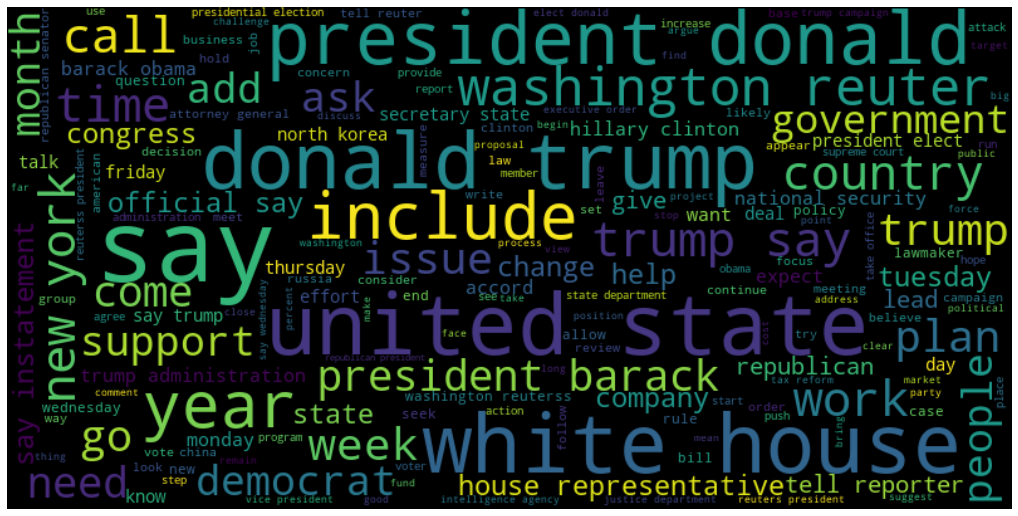

In [61]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 667)

wordcloud.generate(cleaned)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

#TOTAL DF

In [ ]:
dff

In [ ]:
dft

In [65]:
df = pd.concat([dff,dft]).reset_index(drop=True)
df

,text,TypeNews
0,donald trump couldnwish americanshappy new yea...,0
1,house intelligence committee chairman devin nu...,0
2,friday reveal milwaukee sheriff david clarke c...,0
3,christmas day donald trump announce work follo...,0
4,pope francis annual christmas day message rebu...,0
...,...,...
17495,washington reuters republican donald trump nea...,1
17496,new york reuter americans view islam unfavorab...,1
17497,washington reuterss house representatives spea...,1
17498,washington new york reuters republican donald ...,1


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      17500 non-null  object
 1   TypeNews  17500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 273.6+ KB


In [66]:
#EDA
cleaned = ' '.join(df['text'].to_list())

(-0.5, 799.5, 399.5, -0.5)

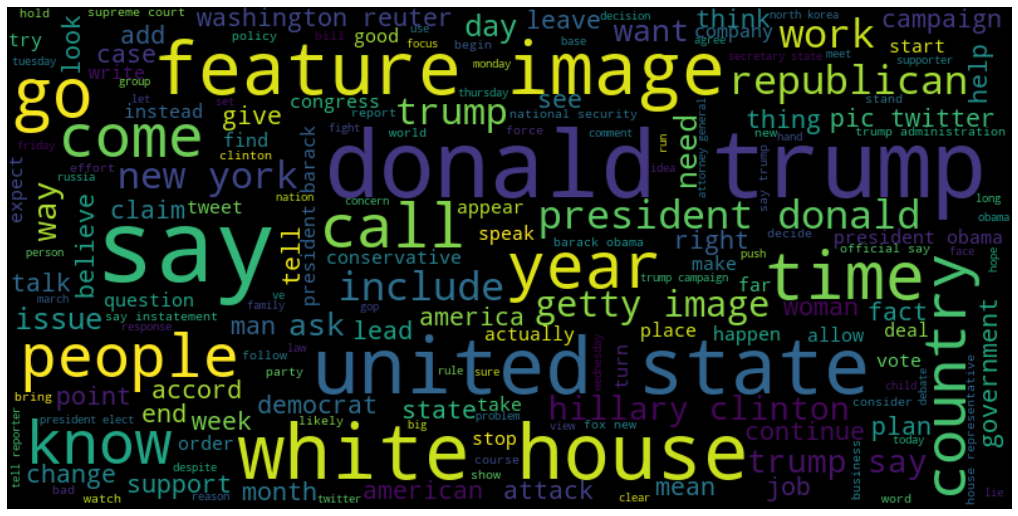

In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 667)

wordcloud.generate(cleaned)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

### BAG OF WORDS

In [68]:
X = df['text'] # FEATURES
y = df['TypeNews'] # TARGET

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

X_ = vectorizer.fit_transform(X).toarray()
X_

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_ = tfidfconverter.fit_transform(X_).toarray()
X_

### SPLIT

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [72]:
labels = ['Fake','True']

##MODELING

###RANDOMFOREST

In [73]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)
classifier.fit(X_train, y_train) 

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=667)

In [74]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9954285714285714


##CM

Text(69.0, 0.5, 'True')

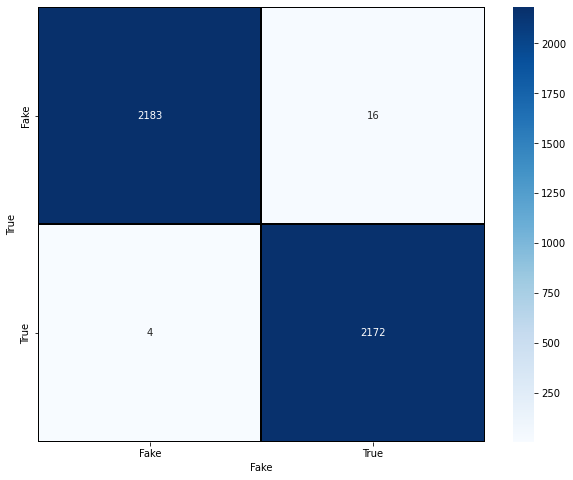

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Fake")
plt.ylabel("True")

In [ ]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

##ROC AUC

In [83]:
!pip install plot-metric --quiet

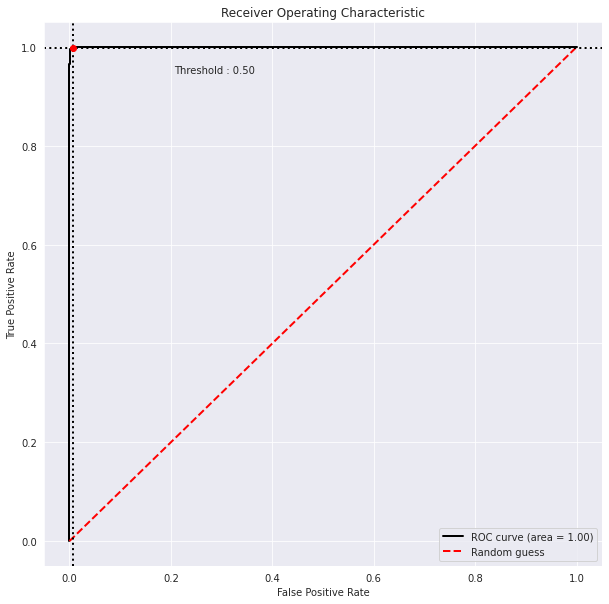

In [84]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

In [86]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test,y_pred_proba)

0.9999297809164593

##PIPELINE

In [87]:
# X = features raw on text format
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [88]:
from sklearn.pipeline import Pipeline

text_preprocess = TextPreprocessor(n_jobs=-1)
bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidf = TfidfTransformer()
classifier = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)

pipe = Pipeline([
                ('lemma_stop_rem',text_preprocess),
                ('bow',bow),
                ('tfidf',tfidf),
                ('clf',classifier),
                ])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)
test_data_accuracy = accuracy_score(y_test,predicted)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9956571428571429


In [89]:
#save pipeline model
import joblib
joblib.dump(pipe,'pipe_news.pkl')

['pipe_news.pkl']

In [113]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/testnews.xlsx


--2022-04-26 09:41:28--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/testnews.xlsx
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.149.158
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.149.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43881 (43K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘testnews.xlsx.1’

testnews.xlsx.1     100%[===================>]  42.85K  --.-KB/s    in 0.1s    

2022-04-26 09:41:29 (318 KB/s) - ‘testnews.xlsx.1’ saved [43881/43881]



In [114]:
dftest = pd.read_excel('testnews.xlsx') 
dftest

,text,label
0,By Dady Chery and Gilbert MercierAll writers ...,0
1,Vic Bishop Waking TimesOur reality is carefull...,0
2,21st Century Wire says As 21WIRE reported earl...,0
3,21st Century Wire says It s a familiar theme. ...,0
4,Patrick Henningsen 21st Century WireRemember ...,0
5,21st Century Wire says Al Jazeera America will...,0
6,21st Century Wire says As 21WIRE predicted in ...,0
7,"SAO PAULO (Reuters) - Cesar Mata Pires, the ow...",1
8,GENEVA (Reuters) - North Korea and the United ...,1
9,GENEVA (Reuters) - North Korea and the United ...,1


In [115]:
input_data = dftest["text"]
prediction = pipe.predict(input_data)


In [117]:
prediction

array([0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1])

In [118]:
dftest["label2"]=prediction

In [119]:
dftest

,text,label,label2
0,By Dady Chery and Gilbert MercierAll writers ...,0,0
1,Vic Bishop Waking TimesOur reality is carefull...,0,0
2,21st Century Wire says As 21WIRE reported earl...,0,1
3,21st Century Wire says It s a familiar theme. ...,0,1
4,Patrick Henningsen 21st Century WireRemember ...,0,1
5,21st Century Wire says Al Jazeera America will...,0,0
6,21st Century Wire says As 21WIRE predicted in ...,0,0
7,"SAO PAULO (Reuters) - Cesar Mata Pires, the ow...",1,1
8,GENEVA (Reuters) - North Korea and the United ...,1,1
9,GENEVA (Reuters) - North Korea and the United ...,1,1


In [120]:
dftest.to_excel("newtest.xlsx")